#  Capstone Project - Starbucks 

In [13]:
import base64
import os
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display_html
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.preprocessing import robust_scale, quantile_transform, scale

In [3]:
## Global definitions

data_dir = 'data'

pd.set_option('display.precision', 2)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
## global functions

def load_dataframe(data_path):
    """Create a dataframe from a json file"""
    return pd.read_json(data_path, orient='records', lines=True)


def convert_fig_to_html(figure):
    """
    Convert a given matplotlib figure to HTML code
    
    Attributes:
    figure (matplotlib.figure.Figure): Generated without using pyplot.
    
    Return:
    return: img-html tag containing the figure data
    """
    # Save figure to a temporary buffer
    buf = BytesIO()
    figure.savefig(buf, format="png")
    # Embed the result in the html output
    data = base64.b64encode(buf.getbuffer()).decode("ascii")
    return f'<img src="data:image/png;base64,{data}" ' \
            'style="display:inline;top:0%"/>'

## Data exploration

### Portfolio

In [5]:
rows, cols = portfolio.shape
print(f'There are {rows} rows and {cols} columns.\n')
portfolio

There are 10 rows and 6 columns.



,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


There are three types of offers that can be sent: buy-one-get-one (BOGO), discount, and informational:

    In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount.
    In a discount, a user gains a reward equal to a fraction of the amount spent.
    In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend.

Offers can be delivered via multiple channels:

    email
    social media
    web
    Mobile.
    
Every offer has a validity period (duration) before the offer expires.

### Profile



In [6]:
rows, cols = profile.shape
print(f'There are {rows} rows and {cols} columns.\n')
profile.head()

There are 17000 rows and 5 columns.



,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


At a glance, it is possible to notice empty values in columns income and gender, as well as missing value encoded as 118 in the column age.

In [8]:
cust = len(profile['id'].unique().tolist())
print(f'On {len(profile)} records we have {cust} customers')

On 17000 records we have 17000 customers


It seems that there are no duplicates.

In [9]:
# To transform the feature, we create a new column
profile['member_on'] = pd.to_datetime(profile['became_member_on'].astype(str)).dt.date
profile.drop('became_member_on', 1, inplace=True)

There are some missing values in _gender_ and _income_: let's dive in this subset.

In [10]:
profile.loc[profile['gender'].isnull()].describe()

,age,income
count,2175.0,0.0
mean,118.0,NaN
std,0.0,NaN
min,118.0,NaN
25%,118.0,NaN
50%,118.0,NaN
75%,118.0,NaN
max,118.0,NaN


It seems like _income_ is always null and _age_ is always 118. Since we basically have no info on these profiles, we can safely drop them.

In [11]:
profile = profile.loc[profile['gender'].isnull() == False]

rows, cols = profile.shape
print(f'After data preparation, we have {rows} rows and {cols} columns.\n')

After data preparation, we have 14825 rows and 5 columns.



/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


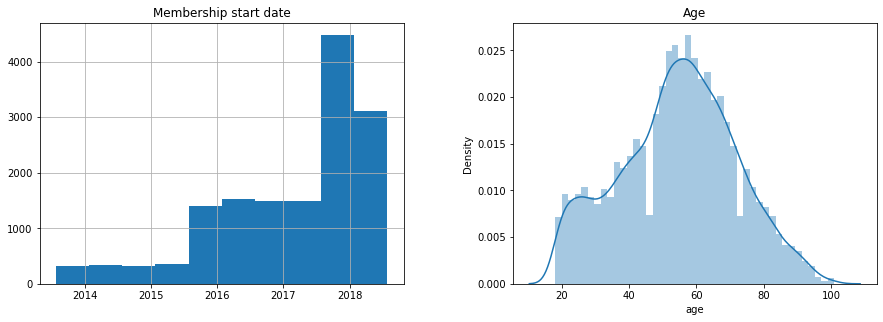


Membership start dates range from 2013-07-29 to 2018-07-26.



In [14]:
plt.subplots(1, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.subplot(222)
plt.title('Age')
sns.distplot(profile['age'])

plt.subplot(221)
plt.title('Membership start date')
profile['member_on'].hist()

plt.show()


print('\nMembership start dates range from {} to {}.\n'.format(
    profile['member_on'].min().strftime('%Y-%m-%d'), profile['member_on'].max().strftime('%Y-%m-%d')
))

Some considerations:
- Analyzing the graphs above, we can see that although the age is normally distributed among the population, there is a local peak around the interval 20 ~ 25. Apparently, this deviation is not a problem to be handled beforehand. However, this is a point to be taken into consideration if networks have difficulty to converge. Hence, simply standardization for this feature seems to be good enough, as shown in the graphs below. 
- the customers are quite new members, since the memberships are concentrated from the last part of 2017 onwards

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


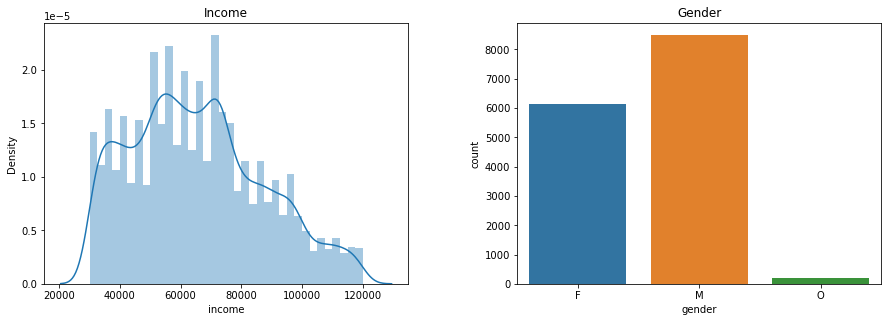

In [15]:
plt.subplots(1, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.subplot(222)
plt.title('Gender')
sns.countplot(x='gender', data=profile)

plt.subplot(221)
plt.title('Income')
sns.distplot(profile['income'])

plt.show()


Some considerations:
- there is a third gender O, with very few records
- These graphs show us that income is not a well distributed feature.

### Transcript

This dataframe contains the list of all actions on offers and transactions, with the relative information about money and time.

_Data preparation:_
- Analyse the _value_ feature and extract the information

In [16]:
display(transcript.head())
display(pd.DataFrame(transcript.event.value_counts()).T \
        .assign(missing=transcript.event.isna().sum()) \
        .assign(total=transcript.count()) \
        .style.set_caption('Count events'))

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


,transaction,offer received,offer viewed,offer completed,missing,total
event,138953,76277,57725,33579,0,306534


The first step to understand this data set is splitting the value column, 

so that it is possible to analyze the relationship between events and results.

In [17]:
transcript = transcript.join(
    pd.DataFrame.from_records(transcript.pop('value')))
transcript.offer_id.update(transcript.pop('offer id'))

display(pd.DataFrame().append([
    transcript.query('event=="offer received"').head(),
    transcript.query('event=="offer viewed"').head(),
    transcript.query('event=="transaction"').head(),
    transcript.query('event=="offer completed"').head(),
    transcript.query('person=="78afa995795e4d85b5d9ceeca43f5fef"').head()]))

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN


In the representative dataset above, we notice that:

* offer received and offer viewed have an associated offer id
* transaction has an amount value that indicates how much the customer spent
* offer completed is associated to a reward value
* every event is informed with person and time
* distinct events can occur to the same person at the same time

So that, we need to check if these statements are always true.

#### Check missing data

In [20]:
display(pd.DataFrame(
    {'offer received':
         transcript.query('event=="offer received"').notna().all(),
     'offer viewed':
         transcript.query('event=="offer viewed"').notna().all(),
     'transaction':
         transcript.query('event=="transaction"').notna().all(),
     'offer completed':
         transcript.query('event=="offer completed"').notna().all()
    }).T.style.set_caption('Is there missing information?'))

display(pd.DataFrame(
    {'offer received':
         transcript.query('event=="offer received"').isna().all(),
     'offer viewed':
         transcript.query('event=="offer viewed"').isna().all(),
     'transaction':
         transcript.query('event=="transaction"').isna().all(),
     'offer completed':
         transcript.query('event=="offer completed"').isna().all()
    }).T.style.set_caption('Is there event with extraneous information provided?'))

,person,event,time,amount,offer_id,reward
offer received,True,True,True,False,True,False
offer viewed,True,True,True,False,True,False
transaction,True,True,True,True,False,False
offer completed,True,True,True,False,True,True


,person,event,time,amount,offer_id,reward
offer received,False,False,False,True,False,True
offer viewed,False,False,False,True,False,True
transaction,False,False,False,False,True,True
offer completed,False,False,False,True,False,False


According to these verifications, there is no missing nor extraneous information in this dataset.

Now, we neeed to verify if there is some inconsistent values in it.

#### Events feature is important and should be explored well.

,transaction,offer received,offer viewed,offer completed
event,138953,76277,57725,33579


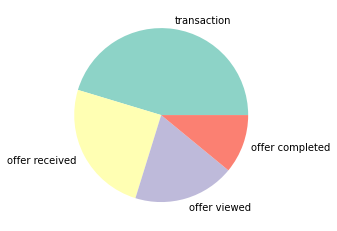

,reward,channels,difficulty,duration,offer_type,received,viewed,completed
id,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,7,bogo,7658,6716,3688.0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo,7593,7298,3331.0
3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,4,informational,7617,4144,NaN
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,7677,4171,4354.0
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,7668,2663,3420.0
2298d6c36e964ae4a3e7e9706d1fb8c2,3,"[web, email, mobile, social]",7,7,discount,7646,7337,5156.0
fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,7597,7327,5317.0
5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,3,informational,7618,6687,NaN
f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo,7571,7264,4296.0


In [23]:
cmap = plt.get_cmap("Set3")
colors = cmap(range(10))

## Plot the number of events that occurred.
display(pd.DataFrame(transcript.event.value_counts()).T)
ax = transcript.event.value_counts().plot.pie(colors=colors)
ax.set_ylabel('')
plt.show()

## Count offers received, viewed, and completed
offer_event = portfolio.set_index('id')
offer_event = offer_event.assign(
    received=pd.DataFrame(
        transcript.query('event == "offer received"')
        .offer_id.value_counts()))
offer_event = offer_event.assign(
    viewed=pd.DataFrame(
        transcript.query('event == "offer viewed"')
        .offer_id.value_counts()))
offer_event = offer_event.assign(
    completed=pd.DataFrame(
        transcript.query('event == "offer completed"')
        .offer_id.value_counts()))
display(offer_event)

There is no anomaly detected in the data related to events.

Besides that, we note a correlation between views and channels. Not surprisingly, the more channels used to deliver the offer, the better. Additionally, using social media seems to be the most effective channel.

Furthermore, there is some correlation between offer completion and features reward, difficulty, and duration. However, it seems more related to the number of offers received.


#### Second most important feature to explore is transactions

In [27]:
amount_desc = pd.DataFrame(transcript.amount.describe()).style \
    .set_caption('Total') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')

transcript_by_person = transcript.groupby('person')
amount_count_desc = pd.DataFrame(transcript_by_person.amount.count().describe()).style \
    .set_caption('Count by person') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')
amount_count_sum = pd.DataFrame(transcript_by_person.amount.sum().describe()).style \
    .set_caption('Sum by person') \
    .set_table_attributes('style="display:inline;' \
                          'vertical-align:top"')

display_html(
    '<left>' \
    + amount_desc._repr_html_() \
    + ' ' \
    + amount_count_desc._repr_html_() \
    + ' ' \
    + amount_count_sum._repr_html_() \
    + '</left>',
    raw=True)

,amount
count,138953.00
mean,12.78
std,30.25
min,0.05
25%,2.78
50%,8.89
75%,18.07
max,1062.28
,amount
count,17000.00


These description tables show us some interesting points.

* There are customers who did not make one single purchase in the period
* There are anomalous values in the amount feature

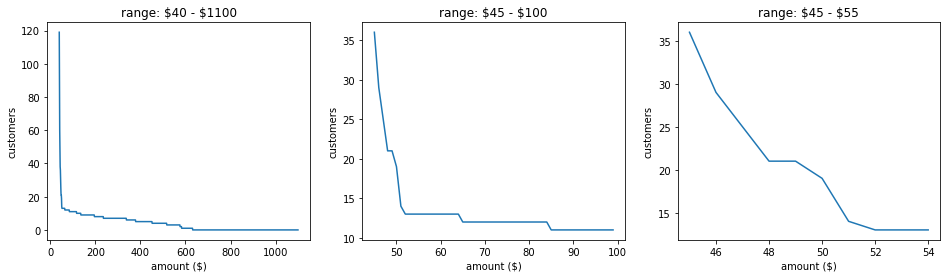

Number of customers with more than 1 transaction with a value >= $50,00: 19
Number of customers with transactions with a value >= $50,00: 687


In [33]:
fig, axs = plt.subplots(figsize=(16,4), nrows=1, ncols=3)


n_users = []
values = range(45,55)
for v in values:
    n_users.append(transcript[transcript.amount > v] \
                   .person.duplicated().sum())
axs[2].plot(values, n_users)
axs[2].set_title('range: \$45 - \$55')
axs[2].set_xlabel('amount ($)')
axs[2].set_ylabel('customers')

n_users = []
values = range(40,1100)
for v in values:
    n_users.append(transcript[transcript.amount > v] \
                   .person.duplicated().sum())
axs[0].plot(values, n_users)
axs[0].set_title('range: \$40 - \$1100')
axs[0].set_xlabel('amount ($)')
axs[0].set_ylabel('customers')

n_users = []
values = range(45,100)
for v in values:
    n_users.append(transcript[transcript.amount > v] \
                   .person.duplicated().sum())
axs[1].plot(values, n_users)
axs[1].set_title('range: \$45 - \$100')
axs[1].set_xlabel('amount ($)')
axs[1].set_ylabel('customers')



plt.show()


print('Number of customers with more than 1 transaction with a value >= $50,00:',
       transcript[transcript.amount >= 50].person.duplicated().sum())
print('Number of customers with transactions with a value >= $50,00:',
       transcript[transcript.amount >= 50].person.nunique())


Number of customers with expense less than 50 dollars are max.
Above graph gives idea on what range and offer should be.

It is quite clear that one purchase with a value of \$1,062.28 in this dataset is an anomaly. However, it is especially tricky finding the value that correctly classifies outliers.
I tried to define this value by finding the number of times one customer repeats transactions with a similar amount.

The three graphs on the top show the number of customers who repeat a transaction with a value higher than a certain amount. Around the value 50, that number tends to stabilize.
By setting the threshold to $50, there are 668 customers with transactions higher than this amount, and only 14 of them repeat a similar transaction.

The three graphs on the bottom present transactions with value clipped to \$50.